In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
from sklearn.preprocessing import KBinsDiscretizer, StandardScaler

In [3]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [4]:
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_curve, confusion_matrix

Описание данных

https://archive.ics.uci.edu/ml/datasets/Cardiotocography

Data Set Information:

2126 fetal cardiotocograms (CTGs) were automatically processed and the respective diagnostic features measured. The CTGs were also classified by three expert obstetricians and a consensus classification label assigned to each of them. Classification was both with respect to a morphologic pattern (A, B, C. ...) and to a fetal state (N, S, P). Therefore the dataset can be used either for 10-class or 3-class experiments.

// Столбец с 10 классами удалила


Attribute Information:

LB - FHR baseline (beats per minute)
AC - # of accelerations per second
FM - # of fetal movements per second
UC - # of uterine contractions per second
DL - # of light decelerations per second
DS - # of severe decelerations per second
DP - # of prolongued decelerations per second
ASTV - percentage of time with abnormal short term variability
MSTV - mean value of short term variability
ALTV - percentage of time with abnormal long term variability
MLTV - mean value of long term variability
Width - width of FHR histogram
Min - minimum of FHR histogram
Max - Maximum of FHR histogram
Nmax - # of histogram peaks
Nzeros - # of histogram zeros
Mode - histogram mode
Mean - histogram mean
Median - histogram median
Variance - histogram variance
Tendency - histogram tendency

NSP - fetal state class code (N=normal; S=suspect; P=pathologic)



In [5]:
df = pd.read_csv('cardio.csv', sep=";")

In [6]:
df.head(10)

,FileName,Date,SegFile,b,e,LBE,LB,AC,FM,UC,...,B,C,D,E,AD,DE,LD,FS,SUSP,NSP
0,Variab10.txt,01.12.1996,CTG0001.txt,240.0,357.0,120.0,120.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0
1,Fmcs_1.txt,03.05.1996,CTG0002.txt,5.0,632.0,132.0,132.0,4.0,0.0,4.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,Fmcs_1.txt,03.05.1996,CTG0003.txt,177.0,779.0,133.0,133.0,2.0,0.0,5.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,Fmcs_1.txt,03.05.1996,CTG0004.txt,411.0,1192.0,134.0,134.0,2.0,0.0,6.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,Fmcs_1.txt,03.05.1996,CTG0005.txt,533.0,1147.0,132.0,132.0,4.0,0.0,5.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,Fmcs_2.txt,03.05.1996,CTG0006.txt,0.0,953.0,134.0,134.0,1.0,0.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0
6,Fmcs_2.txt,03.05.1996,CTG0007.txt,240.0,953.0,134.0,134.0,1.0,0.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0
7,Hasc_1.txt,22.02.1995,CTG0008.txt,62.0,679.0,122.0,122.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0
8,Hasc_1.txt,22.02.1995,CTG0009.txt,120.0,779.0,122.0,122.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0
9,Hasc_1.txt,22.02.1995,CTG0010.txt,181.0,1192.0,122.0,122.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0


In [7]:
# df.info()

In [8]:
df['NSP'].value_counts()

1.0    1655
2.0     295
3.0     176
Name: NSP, dtype: int64

Исходно в задаче 3 класса. Для тренировки оставляю только два - больных и здоровых. Группу под вопросом удвляю.

In [9]:
df= df.loc[df['NSP']!=2]

In [10]:
df['NSP'].value_counts()

1.0    1655
3.0     176
Name: NSP, dtype: int64

In [11]:
df['NSP'] = df['NSP'].map(lambda x: 0 if x==1 else 1)

In [12]:
df['NSP'].value_counts()

0    1655
1     179
Name: NSP, dtype: int64

In [13]:
# df.isna().sum()

In [14]:
df['SegFile'].nunique(), df.shape

(1831, (1834, 39))

In [15]:
df = df.loc[df['SegFile'].notna()]

In [16]:
df.isna().sum().sum()

0

In [17]:
df = df.drop(['FileName', 'Date', 'SegFile'], axis=1)

In [18]:
df.head()

,b,e,LBE,LB,AC,FM,UC,ASTV,MSTV,ALTV,...,B,C,D,E,AD,DE,LD,FS,SUSP,NSP
1,5.0,632.0,132.0,132.0,4.0,0.0,4.0,17.0,"2,1",0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
2,177.0,779.0,133.0,133.0,2.0,0.0,5.0,16.0,"2,1",0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
3,411.0,1192.0,134.0,134.0,2.0,0.0,6.0,16.0,"2,4",0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
4,533.0,1147.0,132.0,132.0,4.0,0.0,5.0,16.0,"2,4",0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
5,0.0,953.0,134.0,134.0,1.0,0.0,10.0,26.0,"5,9",0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1


In [19]:
df.shape

(1831, 36)

In [20]:
df.drop_duplicates(inplace=True)

<AxesSubplot:>

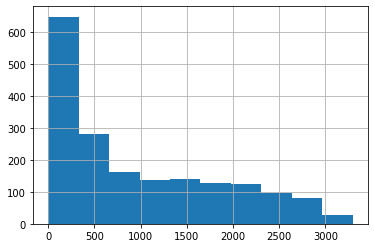

In [21]:
df['b'].hist()

<AxesSubplot:>

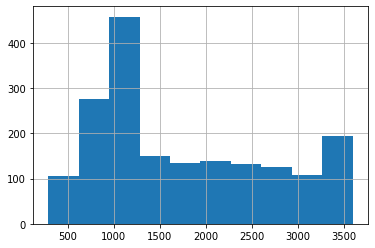

In [22]:
df['e'].hist()

<AxesSubplot:>

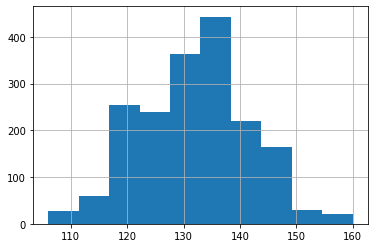

In [23]:
df['LBE'].hist()

<AxesSubplot:>

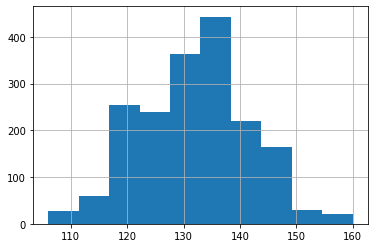

In [24]:
df['LB'].hist()

In [25]:
df1 = df.drop('LBE', 1)
df = df.drop('LB', 1)

<AxesSubplot:>

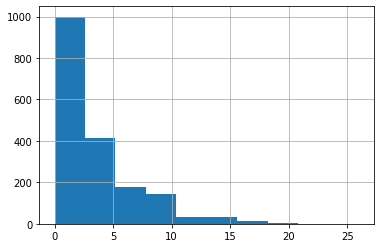

In [26]:
df['AC'].hist()

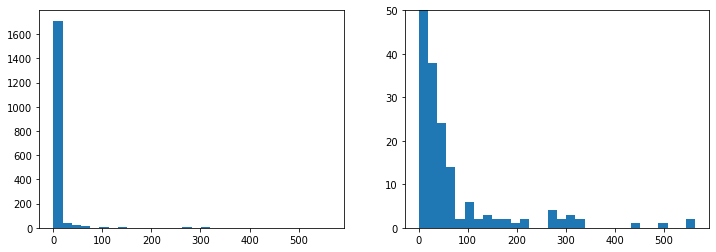

In [27]:
plt.figure(figsize = (12, 4))
plt.subplot(121)
plt.hist(df['FM'], bins=30)

plt.subplot(122)
plt.hist(df['FM'], bins=30)
plt.ylim(0, 50)

plt.show()

In [28]:
# kb = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform')
# kb.fit_transform(df[['FM']])

# kb.bin_edges_

In [29]:
def bins_FM(X):
    a = X.copy()
    for i in range(len(X)):
        if 0 < X.iloc[i] <= 100:
            a.iloc[i] = 1
        elif X.iloc[i] > 100:
            a.iloc[i] = 2
    return a                

In [30]:
# df['FM_bins'] = bins_FM(df['FM'])

In [31]:
# df['FM_bins'].value_counts()

<AxesSubplot:>

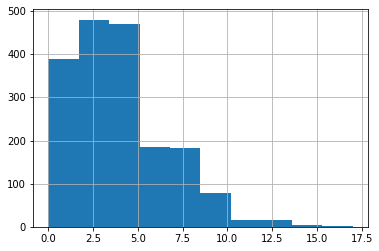

In [32]:
df['UC'].hist()

<AxesSubplot:>

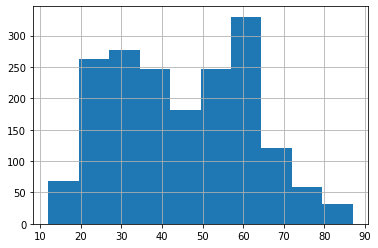

In [33]:
df['ASTV'].hist()

<AxesSubplot:>

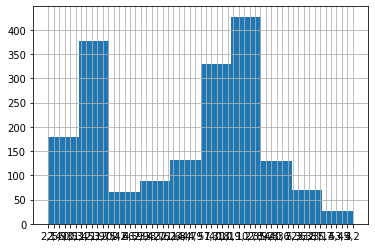

In [34]:
df['MSTV'].hist()

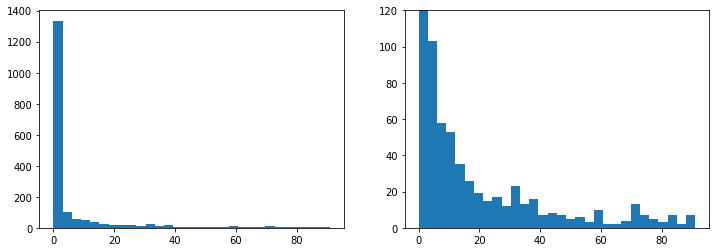

In [35]:
plt.figure(figsize = (12, 4))
plt.subplot(121)
plt.hist(df['ALTV'], bins=30)

plt.subplot(122)
plt.hist(df['ALTV'], bins=30)
plt.ylim(0, 120)

plt.show()

In [36]:
df['ALTV'].value_counts()

0.0     1212
1.0       51
2.0       41
5.0       39
4.0       34
        ... 
85.0       1
52.0       1
47.0       1
63.0       1
79.0       1
Name: ALTV, Length: 82, dtype: int64

In [37]:
def bins_ALTV(X):
    a = X.copy()
    for i in range(len(X)):
        if 0 < X.iloc[i] <= 20:
            a.iloc[i] = 1
        elif X.iloc[i] > 20:
            a.iloc[i] = 2
    return a        

In [38]:
# df['ALTV_bins'] = bins_ALTV(df['ALTV'])

In [39]:
# df['ALTV_bins'].value_counts()

<AxesSubplot:>

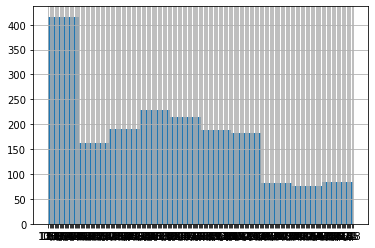

In [40]:
df['MLTV'].hist()

<AxesSubplot:>

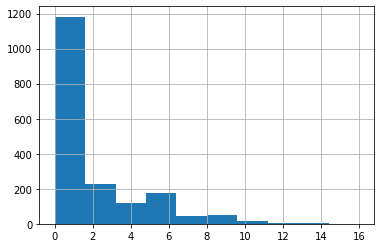

In [41]:
df['DL'].hist()

In [42]:
df['DS'].value_counts()

0.0    1816
1.0       7
Name: DS, dtype: int64

In [43]:
df['DP'].value_counts()

0.0    1660
1.0      97
2.0      47
3.0      18
4.0       1
Name: DP, dtype: int64

In [44]:
df['DR'].value_counts()

0.0    1823
Name: DR, dtype: int64

In [45]:
df = df.drop('DR', 1)

<AxesSubplot:>

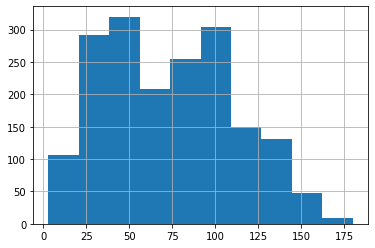

In [46]:
df['Width'].hist()

<AxesSubplot:>

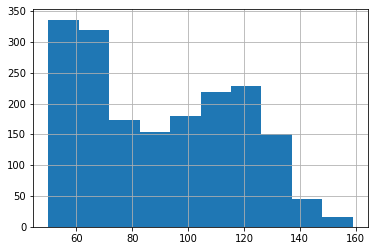

In [47]:
df['Min'].hist()

<AxesSubplot:>

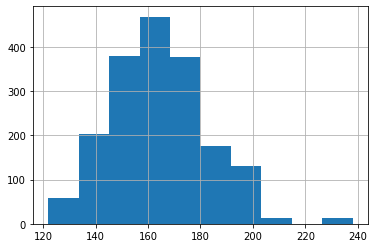

In [48]:
df['Max'].hist()

<AxesSubplot:>

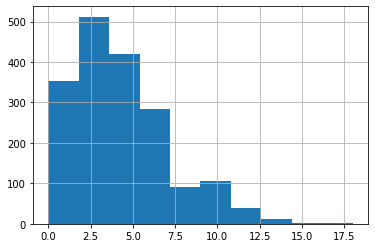

In [49]:
df['Nmax'].hist()

<AxesSubplot:>

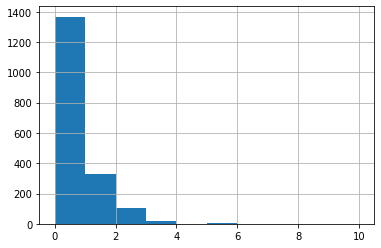

In [50]:
df['Nzeros'].hist()

In [51]:
df['Nzeros'].value_counts()

0.0     1367
1.0      331
2.0      102
3.0       19
5.0        2
10.0       1
4.0        1
Name: Nzeros, dtype: int64

In [52]:
def bins_Nzeros(X):
    a = X.copy()
    for i in range(len(X)):
        if 0 < X.iloc[i] <= 2:
            a.iloc[i] = 1
        elif X.iloc[i] > 2:
            a.iloc[i] = 2
    return a        

In [53]:
# df['Nzeros_bins'] = bins_Nzeros(df['Nzeros'])

In [54]:
# df['Nzeros_bins'].value_counts()

<AxesSubplot:>

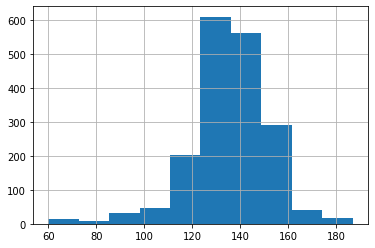

In [55]:
df['Mode'].hist()

<AxesSubplot:>

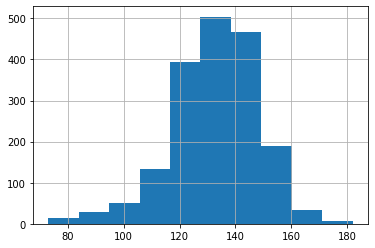

In [56]:
df['Mean'].hist()

<AxesSubplot:>

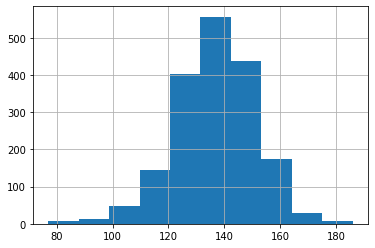

In [57]:
df['Median'].hist()

<AxesSubplot:>

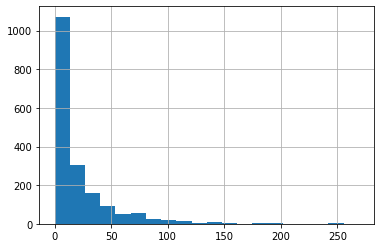

In [58]:
df['Variance'].hist(bins=20)

In [59]:
# df['Variance'].value_counts()

In [60]:
df['Tendency'].value_counts()

 0.0    974
 1.0    699
-1.0    150
Name: Tendency, dtype: int64

In [61]:
df['A'].value_counts()

0.0    1442
1.0     381
Name: A, dtype: int64

In [62]:
df['B'].value_counts()

0.0    1248
1.0     575
Name: B, dtype: int64

In [63]:
df['C'].value_counts()

0.0    1772
1.0      51
Name: C, dtype: int64

In [64]:
df['D'].value_counts()

0.0    1742
1.0      81
Name: D, dtype: int64

In [65]:
df['E'].value_counts()

0.0    1820
1.0       3
Name: E, dtype: int64

In [66]:
df['AD'].value_counts()

0.0    1493
1.0     330
Name: AD, dtype: int64

In [67]:
df['DE'].value_counts()

0.0    1596
1.0     227
Name: DE, dtype: int64

In [68]:
df['LD'].value_counts()

0.0    1716
1.0     107
Name: LD, dtype: int64

In [69]:
df['FS'].value_counts()

0.0    1756
1.0      67
Name: FS, dtype: int64

In [70]:
df['SUSP'].value_counts()

0.0    1822
1.0       1
Name: SUSP, dtype: int64

In [71]:
df = df.drop('SUSP', 1)

In [72]:
# 'MSTV', 'ASTV' - cor, Mean-Mode-Median, 

In [73]:
df.columns

Index(['b', 'e', 'LBE', 'AC', 'FM', 'UC', 'ASTV', 'MSTV', 'ALTV', 'MLTV', 'DL',
       'DS', 'DP', 'Width', 'Min', 'Max', 'Nmax', 'Nzeros', 'Mode', 'Mean',
       'Median', 'Variance', 'Tendency', 'A', 'B', 'C', 'D', 'E', 'AD', 'DE',
       'LD', 'FS', 'NSP'],
      dtype='object')

In [74]:
df.shape

(1823, 33)

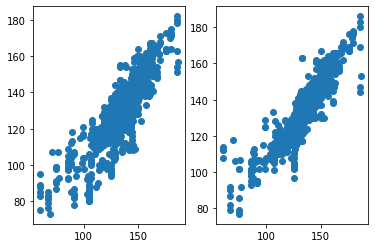

In [75]:
# plt.scatter(df['MSTV'], df['ASTV'])
plt.subplot(121)
plt.scatter(df['Mode'], df['Mean'])
plt.subplot(122)
plt.scatter(df['Mode'], df['Median'])
plt.show()

Из 3х показателей оставлю только медиану

In [76]:
from sklearn.model_selection import train_test_split, GridSearchCV

In [77]:
x_train, x_test, y_train, y_test = train_test_split(df.drop('NSP', 1), df['NSP'], random_state=13, test_size=0.3 )

In [78]:
x_train.shape

(1276, 32)

In [79]:
y_train.value_counts()

0    1138
1     138
Name: NSP, dtype: int64

In [80]:
y_test.value_counts()

0    510
1     37
Name: NSP, dtype: int64

In [81]:
df.groupby('NSP').mean()

,b,e,LBE,AC,FM,UC,ASTV,ALTV,DL,DS,...,Tendency,A,B,C,D,E,AD,DE,LD,FS
NSP,,,,,,,,,,,,,,,,,,,,,
0,954.973301,1784.680218,131.995752,3.431432,6.393811,3.998786,42.486650,5.058252,1.616505,0.000607,...,0.341626,0.231189,0.348908,0.030947,0.04915,0.00182,0.200243,0.137743,0.000000,0.000000
1,847.234286,1640.891429,131.668571,0.331429,15.771429,3.280000,64.554286,22.571429,3.171429,0.034286,...,-0.080000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.611429,0.382857


In [82]:
cont_columns = ['b', 'e', 'LBE', 'AC', 'UC', 'ASTV', 'MSTV', 'ALTV', 'MLTV', 'Width', 'Min', 'Max',
                'Nmax', 'Nzeros', 'Median', 'Variance']
# binary = ['DS', 'A', 'B', 'C', 'D', 'E', 'AD', 'DE', 'LD', 'FS']
binary = ['DS']
# Пришлось убрать часть признаков, т.к. с ними нечего моделировать - по ним можно однозначно ставить диагноз


other = ['DP','Tendency']
new_f = ['FM_bins', 'ALTV_bins', 'Nzeros_bins']

In [83]:
class DataProcessing(BaseEstimator,TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X1 = X.copy()
        ss =  StandardScaler()
        
        X1['MSTV'] = [float(el.replace(",", ".")) for el in X['MSTV']]
        X1['MLTV'] = [float(el.replace(",", ".")) for el in X['MLTV']]
        
        X1['FM_bins'] = bins_FM(X['FM'])  
        X1['ALTV_bins'] = bins_ALTV(X['ALTV'])
        X1['Nzeros_bins'] = bins_Nzeros(X['Nzeros'])
        
        return X1[cont_columns+binary+other+new_f]

In [84]:
# dp = DataProcessing()

# X_train = dp.fit_transform(x_train)
# X_test = dp.fit_transform(x_test)

In [85]:
# model1 = RandomForestClassifier(random_state = 42)

In [86]:
# model1.fit(X_train, y_train)

In [87]:
# model1.feature_importances_

In [88]:
pipeline = Pipeline([
    ('dp', DataProcessing()),
    ('classifier', RandomForestClassifier(random_state = 42)),
])

In [89]:
pipeline.fit(x_train, y_train)

Pipeline(steps=[('dp', DataProcessing()),
                ('classifier', RandomForestClassifier(random_state=42))])

In [90]:
preds = pipeline.predict_proba(x_test)[:, 1]

In [91]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.400000, F-Score=0.959, Precision=0.972, Recall=0.946


In [92]:
# params={'classifier__max_features':[0.2, 0.4, 0.6],
#         'classifier__min_samples_leaf':[1, 2, 3],
#         'classifier__max_depth':[None]
#         }

In [93]:
# grid = GridSearchCV(pipeline,
#                     param_grid=params,
#                     cv=6,
#                     refit=False)

# search = grid.fit(x_train, y_train)
# search.best_params_

In [94]:
# pipeline = Pipeline([
#     ('dp', DataProcessing()),
#     ('classifier', RandomForestClassifier(max_depth=None, max_features=0.2, min_samples_leaf=1, random_state = 42)),
# ])

In [95]:
# pipeline.fit(x_train, y_train)
# preds = pipeline.predict_proba(x_test)[:, 1]

# precision, recall, thresholds = precision_recall_curve(y_test, preds)

# fscore = (2 * precision * recall) / (precision + recall)
# # locate the index of the largest f score
# ix = np.argmax(fscore)
# print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
#                                                                         fscore[ix],
#                                                                         precision[ix],
#                                                                         recall[ix]))

In [96]:
results = pd.DataFrame(columns = ['known_labels_ratio', 'threshold', 'f_score', 'precision', 'recall'])

In [97]:
results = results.append({'known_labels_ratio': 1,
                'threshold': thresholds[ix],
                'f_score': fscore[ix],
                'precision': precision[ix],
                'recall': recall[ix]},
               ignore_index=True)
results

,known_labels_ratio,threshold,f_score,precision,recall
0,1.0,0.4,0.958904,0.972222,0.945946


In [105]:
known_labels_ratio = 0.3
tp = x_train[y_train==1]

x_train['new_label'] = 0
x_train.loc[tp.sample(frac = known_labels_ratio, replace=False).index, 'new_label'] = 1

In [99]:
# rp = np.random.permutation(tp.index)
# data_P = tp.loc[rp[:int(len(rp)*known_labels_ratio)]]
# data_U = np.concatenate((tp.loc[rp[int(len(rp)*known_labels_ratio):]], x_train[y_train==0]), axis=0)

In [106]:
u = x_train[x_train['new_label'] == 0]

new_x_train = pd.concat([x_train.loc[(x_train['new_label'] == 1)], u.sample(frac = 0.5, replace=False)], axis=0)

In [107]:
pipeline.fit(new_x_train.drop('new_label', 1), new_x_train['new_label'])

Pipeline(steps=[('dp', DataProcessing()),
                ('classifier', RandomForestClassifier(random_state=42))])

In [108]:
preds = pipeline.predict_proba(x_test)[:, 1]

In [109]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.100000, F-Score=0.838, Precision=0.838, Recall=0.838


In [117]:
results = results.append({'known_labels_ratio': 0.3,
                'threshold': thresholds[ix],
                'f_score': fscore[ix],
                'precision': precision[ix],
                'recall': recall[ix]},
               ignore_index=True)
results

,known_labels_ratio,threshold,f_score,precision,recall
0,1.0,0.40,0.958904,0.972222,0.945946
1,0.5,0.19,0.906667,0.894737,0.918919
2,0.3,0.10,0.837838,0.837838,0.837838
